# **Problema A - Caso Base**

# Matriz de Costos

In [54]:
import pandas as pd

df_clients = pd.read_csv('./content/base/clients.csv')
df_depots = pd.read_csv('./content/base/depots.csv')
df_vehicles = pd.read_csv('./content/base/vehicles.csv')

In [55]:
df_depots['DepotID'] = df_depots['DepotID'].astype(str)
df_depots['ClientID'] = df_clients['ClientID'].astype(str)
df_vehicles['VehicleName'] = [f'V{i+1}' for i in range(len(df_vehicles))]


coord_depots = list(zip(df_depots['Longitude'], df_depots['Latitude']))

coord_clients = list(zip(df_clients['Longitude'], df_clients['Latitude']))

lugares = coord_depots + coord_clients

In [56]:
vehic_ranges= df_vehicles.set_index('VehicleName')['Range'].to_dict()

## Algortimo Genético

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import time
import csv
from collections import defaultdict
from copy import deepcopy

In [57]:
class GeneticAlgorithmCVRP:
    """
    Algoritmo genétco para caso base de CVRP
    """
    
    def __init__(self, cost_matrix, num_lugares, vehic_ranges, num_vehicles=3, depots=None, 
                 population_size=100, generations=500, mutation_rate=0.2, 
                 crossover_rate=0.8, elitism_rate=0.1, tournament_size=5):
        """
        Inicializar algoritmo genético
        
        Args:
            cost_matrix (np.array): matriz cuadrada de costos entre clientes
            num_lugares (int): Numero total de lugares (clientes y depositos)
            num_vehicles (int): Numero de vehículos
            depots (list): Lista de depóstitos (1-indexed)
            population_size (int): tamaño de la población
            generations (int): numero máximo de generaciones
            mutation_rate (float): probabilidad de mutación
            crossover_rate (float): probabilidad de cruzamiento
            elitism_rate (float): Proporción de soluciones élite a mantener
            tournament_size (int): Size of tournament for selection
        """
        self.cost_matrix = cost_matrix
        self.num_lugares = num_lugares
        self.num_vehicles = num_vehicles
        self.vehicle_ranges  = vehic_ranges
        
        # Default to node 1 if no depots are specified (1-indexed)
        if depots is None:
            self.depots = [1]
        else:
            self.depots = depots
            
        # Create a set of non-depot cities (1-indexed)
        self.non_depots = [i for i in range(1, num_lugares + 1) if i not in self.depots]
        
        # GA parameters
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_rate = elitism_rate
        self.tournament_size = tournament_size
        
        # Results storage
        self.best_solution = None
        self.best_fitness = float('inf')
        self.fitness_history = []
        self.best_solution_history = []
        self.population = []
        
    def initialize_population(self):
        """
        Create an initial population of random solutions.
        
        Each solution is represented as a list of routes, one for each traveler.
        Each route is a sequence of cities (excluding the depot, which is implicit at start and end).
        """
        population = []
        
        for _ in range(self.population_size):
            # Create a random solution
            solution = self._create_random_solution()
            population.append(solution)
            
        self.population = population
        return population
    
    def _create_random_solution(self):
        """
        Create a random valid solution.
        
        Returns:
            List of routes, one per traveler. Each route is a list of cities.
        """
        # Make a copy of non-depot cities that need to be visited
        cities_to_visit = self.non_depots.copy()
        random.shuffle(cities_to_visit)
        
        # Partition the cities among travelers
        routes = [[] for _ in range(self.num_vehicles)]
        
        # Two strategies: either distribute evenly or randomly
        if random.random() < 0.5:  # Distribute evenly
            cities_per_traveler = len(cities_to_visit) // self.num_vehicles
            remainder = len(cities_to_visit) % self.num_vehicles
            
            start_idx = 0
            for i in range(self.num_vehicles):
                # Add one extra city to some travelers if there's a remainder
                extra = 1 if i < remainder else 0
                end_idx = start_idx + cities_per_traveler + extra
                routes[i] = cities_to_visit[start_idx:end_idx]
                start_idx = end_idx
        else:  # Distribute randomly but ensure each traveler has at least one city if possible
            min_cities = min(1, len(cities_to_visit) // self.num_vehicles)
            
            # First, ensure minimum cities per traveler
            for i in range(self.num_vehicles):
                if len(cities_to_visit) >= min_cities:
                    routes[i] = cities_to_visit[:min_cities]
                    cities_to_visit = cities_to_visit[min_cities:]
            
            # Then distribute remaining cities randomly
            while cities_to_visit:
                traveler_idx = random.randint(0, self.num_vehicles - 1)
                routes[traveler_idx].append(cities_to_visit.pop(0))
        
        # Optimize each traveler's route with a random 2-opt improvement
        for i in range(self.num_vehicles):
            if len(routes[i]) > 3:  # Only worth optimizing if route has enough cities
                routes[i] = self._random_2opt(routes[i])
                
        return routes
    
    def _random_2opt(self, route, iterations=5):
        """
        Apply a simple 2-opt local search to improve a single route.
        Only performs a few iterations to maintain diversity in the population.
        """
        best_route = route.copy()
        best_cost = self._route_cost(best_route)
        
        for _ in range(iterations):
            if len(route) < 4:
                break
                
            # Select random segment to reverse
            i, j = sorted(random.sample(range(len(route)), 2))
            
            # Apply 2-opt: reverse the segment between i and j
            new_route = best_route[:i] + best_route[i:j+1][::-1] + best_route[j+1:]
            new_cost = self._route_cost(new_route)
            
            if new_cost < best_cost:
                best_route = new_route
                best_cost = new_cost
                
        return best_route
    
    def _route_cost(self, route):
        """Calculate the cost of a single route including return to depot."""
        if not route:  # Empty route
            return 0
            
        # Default depot is the first one in the list
        depot = self.depots[0]
        
        # Start at depot, visit all cities in route, return to depot
        cost = self.cost_matrix[depot-1][route[0]-1]  # From depot to first city
        
        for i in range(len(route) - 1):
            cost += self.cost_matrix[route[i]-1][route[i+1]-1]
            
        cost += self.cost_matrix[route[-1]-1][depot-1]  # Return to depot
        return cost
    
    def evaluate_fitness(self, solution):
        """Calculate the fitness (total cost) of a solution."""
        total_cost = 0
        penalty    = 0
        
        for vidx, route in enumerate(solution, start=1):
            # coste de la ruta (incluye ida y vuelta al depósito)
            route_dist = self._route_cost(route)
            total_cost += route_dist

        # rango operacional máximo de este vehículo
        max_dist = self.vehicle_ranges.get(vidx, float('inf'))
        if route_dist > max_dist:
            # penaliza cada kilómetro extra con un factor muy grande
            penalty += 1e6 * (route_dist - max_dist)

        return total_cost + penalty
    
    def select_parents(self):
        """
        Select parents using tournament selection.
        
        Returns:
            Two parent solutions
        """
        def tournament():
            participants = random.sample(range(len(self.population)), self.tournament_size)
            participants_fitness = [(p, self.evaluate_fitness(self.population[p])) for p in participants]
            winner = min(participants_fitness, key=lambda x: x[1])[0]
            return self.population[winner]
        
        parent1 = tournament()
        parent2 = tournament()
        return parent1, parent2
    
    def crossover(self, parent1, parent2):
        """
        Perform crossover between two parents.
        
        This uses a specialized route-based crossover operator for MTSP:
        1. Route Exchange Crossover - exchanges whole routes between parents
        2. Route Merge Crossover - merges routes between parents and redistributes cities
        
        Returns:
            Two child solutions
        """
        if random.random() > self.crossover_rate:
            return deepcopy(parent1), deepcopy(parent2)
        
        # Choose crossover type: route exchange or route merge
        if random.random() < 0.5:
            return self._route_exchange_crossover(parent1, parent2)
        else:
            return self._route_merge_crossover(parent1, parent2)
    
    def _route_exchange_crossover(self, parent1, parent2):
        """
        Route Exchange Crossover: exchanges complete routes between parents.
        
        This preserves good routes while creating new combinations.
        """
        child1 = deepcopy(parent1)
        child2 = deepcopy(parent2)
        
        if self.num_vehicles < 2:
            return child1, child2
            
        # Select random routes to exchange
        num_routes_to_exchange = random.randint(1, max(1, self.num_vehicles // 2))
        routes_to_exchange = random.sample(range(self.num_vehicles), num_routes_to_exchange)
        
        # Exchange the selected routes
        for route_idx in routes_to_exchange:
            child1[route_idx], child2[route_idx] = child2[route_idx], child1[route_idx]
            
        # Repair solutions if needed (check for duplicates and missing cities)
        child1 = self._repair_solution(child1)
        child2 = self._repair_solution(child2)
        
        return child1, child2
    
    def _route_merge_crossover(self, parent1, parent2):
        """
        Route Merge Crossover: merges corresponding routes, then rebuilds a valid solution.
        
        This combines parts of routes from both parents, creating more genetic diversity.
        """
        # Collect all cities from both parents (excluding depots)
        all_cities = set(self.non_depots)
        
        # Create empty routes for children
        child1 = [[] for _ in range(self.num_vehicles)]
        child2 = [[] for _ in range(self.num_vehicles)]
        
        # For each traveler's route
        for i in range(self.num_vehicles):
            # Choose crossover points for both parents' routes
            if parent1[i] and parent2[i]:
                # Get crossover points
                p1_cross = random.randint(0, len(parent1[i]))
                p2_cross = random.randint(0, len(parent2[i]))
                
                # Create merged routes (may contain duplicates)
                merged1 = parent1[i][:p1_cross] + parent2[i][p2_cross:]
                merged2 = parent2[i][:p2_cross] + parent1[i][p1_cross:]
                
                # Keep only the first occurrence of each city
                child1[i] = self._remove_duplicates(merged1)
                child2[i] = self._remove_duplicates(merged2)
        
        # Repair solutions to ensure all cities are covered
        child1 = self._repair_solution(child1)
        child2 = self._repair_solution(child2)
        
        return child1, child2
    
    def _remove_duplicates(self, route):
        """Remove duplicate cities from a route, keeping the first occurrence."""
        seen = set()
        result = []
        for city in route:
            if city not in seen:
                seen.add(city)
                result.append(city)
        return result
    
    def _repair_range(self, solution):
        for vidx, route in enumerate(solution, start=1):
            max_dist = self.vehicle_ranges.get(vidx, float('inf'))
            # mientras esta ruta exceda el rango...
            while self._route_cost(route) > max_dist:
                # elimina el cliente que más contribuye al exceso,
                # por ejemplo el más lejano del depósito o el último añadido
                # y redistribúyelo a otro vehículo
                city_to_move = route.pop()  
                # aquí podrías buscar el vehículo con más margen...
                target = min(
                    range(1, self.num_vehicles+1),
                    key=lambda v: abs(self._route_cost(solution[v-1]) - self.vehicle_ranges[v])
                )
                solution[target-1].append(city_to_move)
        return solution
    
    def _repair_solution(self, solution):
        """
        Repair a solution to ensure all cities are visited exactly once.
        
        1. Find missing cities (cities that should be visited but aren't in any route)
        2. Find duplicate cities (cities that appear in multiple routes)
        3. Remove duplicates and add missing cities
        """
        # Get all cities in the solution
        included_cities = []
        for route in solution:
            included_cities.extend(route)
            
        # Find duplicate cities and their positions
        city_counts = defaultdict(list)
        for traveler_idx, route in enumerate(solution):
            for pos, city in enumerate(route):
                city_counts[city].append((traveler_idx, pos))
                
        # Extract duplicate cities (appearing more than once) and missing cities
        duplicate_cities = {city: positions for city, positions in city_counts.items() 
                           if len(positions) > 1}
        missing_cities = [city for city in self.non_depots if city not in included_cities]
        
        # Process duplicates by keeping the first occurrence and marking others for removal
        to_remove = []
        for city, positions in duplicate_cities.items():
            # Keep the first occurrence, mark others for removal
            for traveler_idx, pos in positions[1:]:
                to_remove.append((traveler_idx, pos))
        
        # Sort removals in reverse order (to maintain valid indices when removing)
        to_remove.sort(reverse=True)
        
        # Remove duplicates
        for traveler_idx, pos in to_remove:
            solution[traveler_idx].pop(pos)
        
        # Distribute missing cities to routes
        random.shuffle(missing_cities)
        for city in missing_cities:
            # Choose a route, preferring those with fewer cities for balance
            route_sizes = [(i, len(route)) for i, route in enumerate(solution)]
            route_idx = min(route_sizes, key=lambda x: x[1])[0]
            
            # Insert at a random position
            insert_pos = random.randint(0, len(solution[route_idx]))
            solution[route_idx].insert(insert_pos, city)
        
        sol = self._repair_range(solution)
        return sol
    
    def mutate(self, solution):
        """
        Apply mutation operators to the solution.
        
        Uses several mutation types:
        1. Swap mutation - swaps cities within a route
        2. Insert mutation - moves a city to a different position
        3. Inversion mutation - reverses a segment of a route
        4. Redistribution mutation - moves cities between routes
        
        Returns:
            Mutated solution
        """
        if random.random() > self.mutation_rate:
            return solution
            
        # Choose mutation type
        mutation_type = random.choice(['swap', 'insert', 'invert', 'redistribute'])
        
        if mutation_type == 'swap':
            return self._swap_mutation(solution)
        elif mutation_type == 'insert':
            return self._insert_mutation(solution)
        elif mutation_type == 'invert':
            return self._inversion_mutation(solution)
        else:  # redistribute
            return self._redistribution_mutation(solution)
    
    def _swap_mutation(self, solution):
        """Swap two random cities within a random route."""
        mutated = deepcopy(solution)
        
        # Select a non-empty route
        non_empty_routes = [i for i, route in enumerate(mutated) if len(route) >= 2]
        if not non_empty_routes:
            return mutated
            
        route_idx = random.choice(non_empty_routes)
        route = mutated[route_idx]
        
        # Swap two random positions
        pos1, pos2 = random.sample(range(len(route)), 2)
        route[pos1], route[pos2] = route[pos2], route[pos1]
        
        return mutated
    
    def _insert_mutation(self, solution):
        """Move a random city to a different position in its route."""
        mutated = deepcopy(solution)
        
        # Select a non-empty route
        non_empty_routes = [i for i, route in enumerate(mutated) if len(route) >= 2]
        if not non_empty_routes:
            return mutated
            
        route_idx = random.choice(non_empty_routes)
        route = mutated[route_idx]
        
        # Select a city and a new position
        old_pos = random.randint(0, len(route) - 1)
        new_pos = random.randint(0, len(route) - 1)
        while new_pos == old_pos:
            new_pos = random.randint(0, len(route) - 1)
            
        # Remove city from old position and insert at new position
        city = route.pop(old_pos)
        route.insert(new_pos, city)
        
        return mutated
    
    def _inversion_mutation(self, solution):
        """Reverse a segment of a random route."""
        mutated = deepcopy(solution)
        
        # Select a route with enough cities
        eligible_routes = [i for i, route in enumerate(mutated) if len(route) >= 3]
        if not eligible_routes:
            return mutated
            
        route_idx = random.choice(eligible_routes)
        route = mutated[route_idx]
        
        # Select two positions and reverse the segment between them
        pos1, pos2 = sorted(random.sample(range(len(route)), 2))
        mutated[route_idx] = route[:pos1] + route[pos1:pos2+1][::-1] + route[pos2+1:]
        
        return mutated
    
    def _redistribution_mutation(self, solution):
        """Move a city from one route to another."""
        mutated = deepcopy(solution)
        
        if self.num_vehicles < 2:
            return mutated
            
        # Find a non-empty route to take a city from
        non_empty_routes = [i for i, route in enumerate(mutated) if route]
        if not non_empty_routes:
            return mutated
            
        from_route_idx = random.choice(non_empty_routes)
        to_route_idx = random.randint(0, self.num_vehicles - 1)
        while to_route_idx == from_route_idx:
            to_route_idx = random.randint(0, self.num_vehicles - 1)
            
        # Move a random city from one route to another
        if mutated[from_route_idx]:
            city_pos = random.randint(0, len(mutated[from_route_idx]) - 1)
            city = mutated[from_route_idx].pop(city_pos)
            
            insert_pos = random.randint(0, len(mutated[to_route_idx]))
            mutated[to_route_idx].insert(insert_pos, city)
            
        return mutated
    
    def evolve_population(self):
        """
        Evolve the population to the next generation using elitism, crossover, and mutation.
        """
        # Evaluate current population
        population_fitness = [(i, self.evaluate_fitness(solution)) 
                              for i, solution in enumerate(self.population)]
        
        # Sort by fitness (lower is better)
        population_fitness.sort(key=lambda x: x[1])
        
        # Keep elite solutions
        num_elite = max(1, int(self.elitism_rate * self.population_size))
        elite_indices = [idx for idx, _ in population_fitness[:num_elite]]
        new_population = [deepcopy(self.population[idx]) for idx in elite_indices]
        
        # Fill the rest of the population with offspring
        while len(new_population) < self.population_size:
            # Select parents
            parent1, parent2 = self.select_parents()
            
            # Crossover
            child1, child2 = self.crossover(parent1, parent2)
            
            # Mutation
            child1 = self.mutate(child1)
            child2 = self.mutate(child2)
            
            # Add to new population
            new_population.append(child1)
            if len(new_population) < self.population_size:
                new_population.append(child2)
        
        self.population = new_population
    
    def solve(self, verbose=True, early_stopping_generations=50):
        """
        Run the genetic algorithm to solve the MTSP.
        
        Args:
            verbose (bool): Whether to print progress information
            early_stopping_generations (int): Stop if no improvement for this many generations
            
        Returns:
            best_solution, best_fitness
        """
        # Initialize population
        self.initialize_population()
        
        # Track best solution and convergence
        best_solution = None
        best_fitness = float('inf')
        generations_without_improvement = 0
        start_time = time.time()
        
        # Main loop
        for generation in range(self.generations):
            # Evolve population
            self.evolve_population()
            
            # Find best solution in current population
            current_best = None
            current_best_fitness = float('inf')
            
            for solution in self.population:
                fitness = self.evaluate_fitness(solution)
                if fitness < current_best_fitness:
                    current_best = solution
                    current_best_fitness = fitness
            
            # Update global best
            if current_best_fitness < best_fitness:
                best_solution = deepcopy(current_best)
                best_fitness = current_best_fitness
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1
            
            # Store history
            self.fitness_history.append(current_best_fitness)
            self.best_solution_history.append(best_fitness)
            
            # Print progress
            if verbose and generation % 10 == 0:
                elapsed_time = time.time() - start_time
                print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}, "
                      f"Current Best = {current_best_fitness:.2f}, "
                      f"Time = {elapsed_time:.2f}s")
            
            # Early stopping
            if generations_without_improvement >= early_stopping_generations:
                if verbose:
                    print(f"Early stopping at generation {generation} due to no improvement "
                          f"for {early_stopping_generations} generations.")
                break
        
        # Final results
        self.best_solution = best_solution
        self.best_fitness = best_fitness
        
        if verbose:
            total_time = time.time() - start_time
            print(f"Optimization complete. Best fitness: {best_fitness:.2f}, "
                  f"Time: {total_time:.2f}s")
            
        return best_solution, best_fitness
    
    def plot_convergence(self):
        """Plot the convergence of the genetic algorithm."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.fitness_history, label='Current Generation Best')
        plt.plot(self.best_solution_history, label='All-Time Best')
        plt.xlabel('Generation')
        plt.ylabel('Fitness (Total Cost)')
        plt.title('Genetic Algorithm Convergence')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_solution(self):
        """Visualize the best solution found."""
        if not self.best_solution:
            print("No solution to visualize yet. Run solve() first.")
            return
        
        # Create a directed graph
        G = nx.DiGraph()
        
        # Add all nodes
        for i in range(1, self.num_lugares + 1):
            if i in self.depots:
                G.add_node(i, color='red')  # Depots in red
            else:
                G.add_node(i, color='lightblue')  # Regular cities in blue
        
        # Add edges for each traveler's route
        edge_colors = plt.cm.Set1.colors
        num_colors = len(edge_colors)
        
        for traveler_idx, route in enumerate(self.best_solution):
            if not route:
                continue
                
            # Default depot is the first one in the list
            depot = self.depots[0]
            
            # Add edge from depot to first city
            G.add_edge(depot, route[0], color=edge_colors[traveler_idx % num_colors], 
                       traveler=traveler_idx+1)
            
            # Add edges between cities
            for i in range(len(route) - 1):
                G.add_edge(route[i], route[i+1], color=edge_colors[traveler_idx % num_colors], 
                           traveler=traveler_idx+1)
            
            # Add edge from last city back to depot
            G.add_edge(route[-1], depot, color=edge_colors[traveler_idx % num_colors], 
                       traveler=traveler_idx+1)
        
        # Position nodes using spring layout
        pos = nx.spring_layout(G, seed=42)
        
        # Draw the graph
        plt.figure(figsize=(12, 8))
        
        # Draw nodes
        node_colors = ['red' if i in self.depots else 'lightblue' for i in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
        
        # Draw edges with color by traveler
        for (u, v, data) in G.edges(data=True):
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], 
                                   edge_color=[data['color']], 
                                   width=2, 
                                   arrows=True)
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_weight='bold')
        
        # Add legend
        legend_elements = [plt.Line2D([0], [0], color=edge_colors[i % num_colors], lw=2, 
                                      label=f'Traveler {i+1}') 
                          for i in range(self.num_vehicles)]
        plt.legend(handles=legend_elements)
        
        plt.title('Multiple Traveling Salesmen Solution')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def get_solution_details(self):
        """Return detailed information about the best solution."""
        if not self.best_solution:
            return "No solution found yet."
            
        details = []
        total_cost = 0
        depot = self.depots[0]  # Default to first depot
        
        details.append("Solution Details:")
        details.append(f"Total Fitness (Cost): {self.best_fitness:.2f}")
        details.append(f"Depot: {depot}")
        details.append("")
        
        for i, route in enumerate(self.best_solution):
            if not route:
                cost = 0
                details.append(f"Traveler {i+1}: No cities to visit. Cost: {cost:.2f}")
                continue
                
            route_with_depot = [depot] + route + [depot]
            route_str = " -> ".join(str(city) for city in route_with_depot)
            
            cost = 0
            for j in range(len(route_with_depot) - 1):
                from_city = route_with_depot[j]
                to_city = route_with_depot[j + 1]
                segment_cost = self.cost_matrix[from_city-1][to_city-1]
                cost += segment_cost
                
            total_cost += cost
            details.append(f"Traveler {i+1}: {route_str}. Cost: {cost:.2f}")
            
        details.append("")
        details.append(f"Total Cost: {total_cost:.2f}")
        
        return "\n".join(details)


def read_cost_matrix_csv(filename):
    """
    Reads a cost matrix from a CSV file.

    The first row of the CSV is assumed to contain the node IDs.

    Parameters:
        filename (str): The name of the CSV file.
    
    Returns:
        cost_matrix (np.array): A 2D numpy array representing the cost matrix.
    """
    with open(filename, 'r', newline='') as file:
        reader = csv.reader(file)

        # Skip the header row with node IDs
        next(reader)

        data = list(reader)

    cost_matrix = np.array(data, dtype=float)

    return cost_matrix

### **Ejecución**

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Generation 0: Best Fitness = 1566170.61, Current Best = 1566170.61, Time = 0.09s
Generation 10: Best Fitness = 1263476.07, Current Best = 1263476.07, Time = 0.94s
Generation 20: Best Fitness = 1077972.19, Current Best = 1077972.19, Time = 1.77s
Generation 30: Best Fitness = 1005747.57, Current Best = 1005747.57, Time = 2.66s
Generation 40: Best Fitness = 932097.86, Current Best = 932097.86, Time = 3.91s
Generation 50: Best Fitness = 907325.60, Current Best = 907325.60, Time = 4.44s
Generation 60: Best Fitness = 906537.26, Current Best = 906537.26, Time = 4.92s
Generation 70: Best Fitness = 830552.83, Current Best = 830552.83, Time = 5.39s
Generation 80: Best Fitness = 791741.95, Current Best = 791741.95, Time = 6.18s
Generation 90: Best Fitness = 787193.80, Current Best = 787193.80, Time = 8.66s
Generation 100: Best Fitness = 780038.05, Current Best = 780038.05, Time = 9.31s
Generation 110: Best Fi

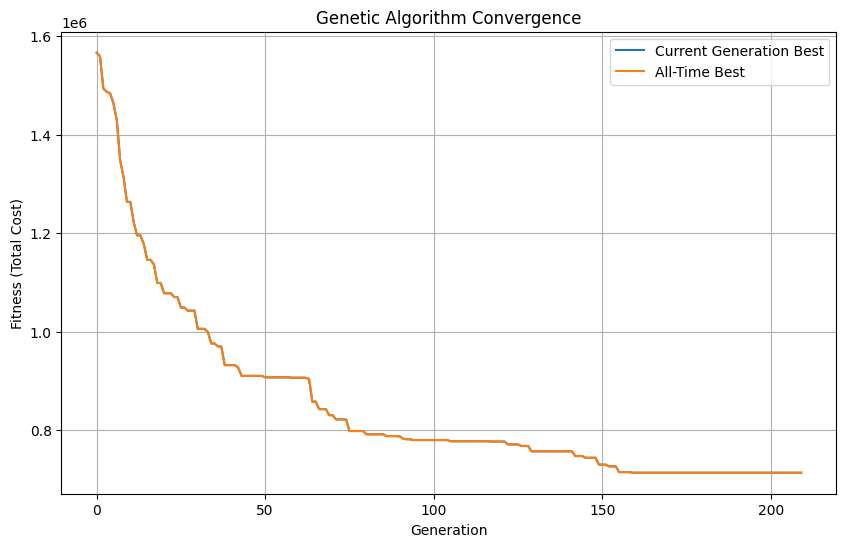

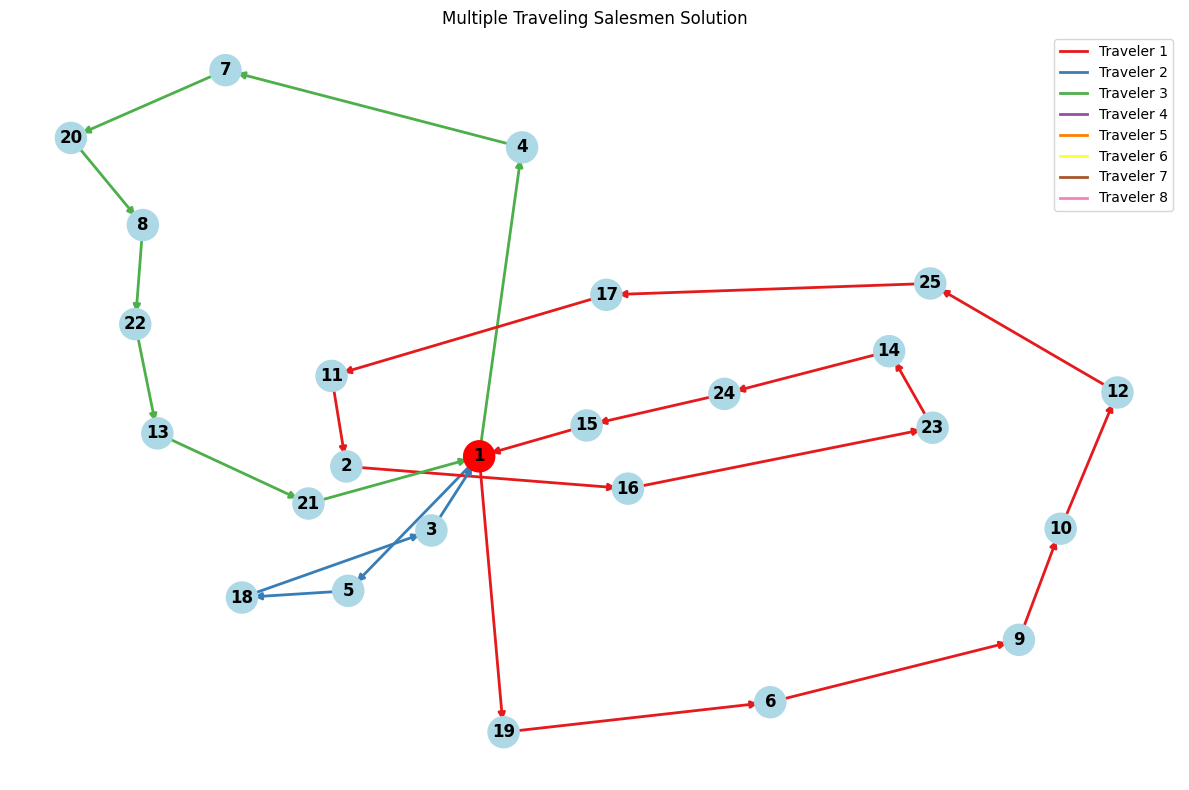

In [59]:
# Read cost matrix from CSV
cost_matrix = read_cost_matrix_csv('content/base/cost_matrix_caso_base.csv')

# Set parameters
num_lugares = len(cost_matrix)
num_vehicles = len(df_vehicles)
depots = [1]  # 1-indexed

# Create and run the genetic algorithm
ga = GeneticAlgorithmCVRP(
    cost_matrix=cost_matrix,
    num_lugares=num_lugares,
    num_vehicles=num_vehicles,
    depots=depots,
    population_size=200,
    generations=500,
    mutation_rate=0.2,
    crossover_rate=0.8,
    elitism_rate=0.1,
    tournament_size=5,
    vehic_ranges=vehic_ranges
)

print(ga.non_depots)

# Solve the problem
best_solution, best_fitness = ga.solve(verbose=True)

# Print detailed solution
print(ga.get_solution_details())

# Plot results
ga.plot_convergence()
ga.plot_solution()